In [ ]:
# Based on https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=h9tECBQCvMv3

### Install detectron2

In [1]:
# To avoid error: NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

import locale
print(locale.getpreferredencoding())

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

UTF-8


In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15280, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 15280 (delta 0), reused 3 (delta 0), pack-reused 15275
Receiving objects: 100% (15280/15280), 6.18 MiB | 12.35 MiB/s, done.
Resolving deltas: 100% (11114/11114), done.


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=f49b1a351801112f27f95aa284d4933fa8c804b99fc0330372db6deee8faf848
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=4a38ffd79a44c62766161e53560fa012cd328bf08fadf0db1c487f626bb6bebd
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a12

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
detectron2: 0.6


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

### Train a custom data set

In [ ]:
# See what needs to be in dataset:
# https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html

In [ ]:
%pip install pycocotools # to convert mask to rle_dict

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os, json
from detectron2.structures import BoxMode

def get_custom_dicts(folder_path):

    # List all files in the folder
    all_files = os.listdir(folder_path)

    # Filter out files that are not in correct pairs (both image and json formats)
    file_pairs = []
    for file in all_files:
        base_name, extension = os.path.splitext(file)
        if extension.lower() == '.jpg' or extension.lower() == '.jpeg' or extension.lower() == '.png':
            json_file = base_name + '.json'
            if json_file in all_files:
                file_pairs.append((file, json_file))

    # Sort from paired list
    image_files = sorted([image_file for image_file, _ in file_pairs])
    json_files = sorted([json_file for _, json_file in file_pairs])

    dataset_dicts = []

    for idx, json_file in enumerate(json_files):

        # Load JSON data from file
        with open(os.path.join(folder_path, json_file), 'r') as file:
            data = json.load(file)

        # Add basic image information to record
        record = {}

        record["file_name"] = os.path.join(folder_path, data["imagePath"])
        record["image_id"] = idx
        record["height"] = data["imageHeight"]
        record["width"] = data["imageWidth"]

        data["imageWidth"]

        shapes = data["shapes"]

        # Save annotations in a list
        objs = []

        # Iterate through each item in the 'shapes' list
        for shape in shapes:

            # Extract points for the current shape
            points = shape['points']

            # segmentation = [item for sublist in points for item in sublist] # unlist points
            # segmentation = points

            # Calculate bounding box
            min_x = min(point[0] for point in points)
            min_y = min(point[1] for point in points)
            max_x = max(point[0] for point in points)
            max_y = max(point[1] for point in points)

            # Create the object dictionary
            obj = {
                "bbox": [min_x, min_y, max_x, max_y],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [points],
                "category_id": 0,  # If only one class, id = 0
            }

            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return(dataset_dicts)

dataset_dicts = get_custom_dicts("gdrive/My Drive/Master Geo Information Science/Internship/Data/kreeften omcirkelt + rest/")

# Split dataset of dicts into training and validation sets
def split_dataset(dataset, split_ratio=0.8):
    """
    Splits a dataset into training and validation sets.

    Args:
        dataset (list): The dataset to be split.
        split_ratio (float): The ratio of the dataset to be used for training.

    Returns:
        tuple: Two lists, first is training set, second is validation set.
    """
    total_samples = len(dataset)
    split_idx = int(total_samples * split_ratio)

    return dataset[:split_idx], dataset[split_idx:]

# Get training and validation dicts
train_dicts, vali_dicts = split_dataset(dataset_dicts)

# Clear/overwrite registered datasets (if necessary)
DatasetCatalog.clear()
# MetadataCatalog.remove("all")
# MetadataCatalog.remove("train")
# MetadataCatalog.remove("vali")

# Register datasets
DatasetCatalog.register("all", lambda:dataset_dicts)
MetadataCatalog.get("train").set(thing_classes=["Kreeft"])
dataset_metadata = MetadataCatalog.get("all")

DatasetCatalog.register("train", lambda:train_dicts)
MetadataCatalog.get("train").set(thing_classes=["Kreeft"])
train_metadata = MetadataCatalog.get("train")

DatasetCatalog.register("vali", lambda:vali_dicts)
MetadataCatalog.get("vali").set(thing_classes=["Kreeft"])
vali_metadata = MetadataCatalog.get("vali")

In [ ]:
# Verify if dataset also in correct format
train_metadata = MetadataCatalog.get("train")
vali_metadata = MetadataCatalog.get("vali")

for d in random.sample(train_dicts, 1):

    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=2)

    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])


## Train

In [ ]:
# Parameters that seem to do reasonably well:

#  it seems that the lower the batch size the more predictions are made

# cfg.SOLVER.IMS_PER_BATCH = 1, cfg.SOLVER.BASE_LR = 0.00025 and with cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16 and 300 iterations (for 100x100 images) (works well)

# "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml" also good, but also only when less than 300/500 iterations (why?)

In [ ]:
%pip install -U sahi # Necessary to save cfg as yaml (and for later SAHI use)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116933 sha256=48a095ce5d7f52a429b8969815e9a1af60f660487631536b72e11b9b9d78710a
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [ ]:
from detectron2.engine import DefaultTrainer
from sahi.utils.detectron2 import export_cfg_as_yaml

# "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml" used by https://www.mdpi.com/2072-4292/12/18/3015 (crops segmentation)?

# Base parameters
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")) # Used "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml" before
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("vali",) # Or should use different one here ?
# cfg.TEST.EVAL_PERIOD = 100
cfg.DATALOADER.NUM_WORKERS = 2 # was 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo (used R 50 FPN before)

cfg.SOLVER.IMS_PER_BATCH = 1  # Was 2. This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # (was 0.00025) pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

cfg.OUTPUT_DIR = ""

# Custom parameters
# Adjust the parameters for detecting smaller objects (?)

# cfg.MODEL.RPN.IN_FEATURES = ['p2', 'p3', 'p4', 'p5', 'p6']
# cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.25, 0.5, 1.0]] #, 2.0, 4.0, 8.0]]
# cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[4], [8], [16], [32], [64], [128]]
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 10240
# cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.7
# cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.5] # Intersection over union threshold

# Set the MASK_FORMAT to bitmask
cfg.INPUT.MASK_FORMAT = "bitmask" # important (?)

# Check if a GPU is available
if torch.cuda.is_available():
    cfg.MODEL.DEVICE = 'cuda' # Otherwise will get Runtime error as no NVIDIA
else:
    cfg.MODEL.DEVICE = 'cpu'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
# trainer = CocoTrainer(cfg) # Overwrite default trainer
trainer.resume_or_load(resume=False)
trainer.train()

[11/21 11:29:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[11/21 11:29:16 d2.engine.train_loop]: Starting training from iteration 0
[11/21 11:29:35 d2.utils.events]:  eta: 0:03:17  iter: 19  total_loss: 2.194  loss_cls: 0.6784  loss_box_reg: 0.3426  loss_mask: 0.6936  loss_rpn_cls: 0.2539  loss_rpn_loc: 0.04958    time: 0.8875  last_time: 0.5382  data_time: 0.3020  last_data_time: 0.0133   lr: 1.6068e-05  max_mem: 3307M
[11/21 11:29:53 d2.utils.events]:  eta: 0:03:18  iter: 39  total_loss: 1.921  loss_cls: 0.5895  loss_box_reg: 0.4421  loss_mask: 0.6876  loss_rpn_cls: 0.1302  loss_rpn_loc: 0.03842    time: 0.8896  last_time: 0.5516  data_time: 0.2662  last_data_time: 0.0071   lr: 3.2718e-05  max_mem: 3307M
[11/21 11:30:09 d2.utils.events]:  eta: 0:03:03  iter: 59  total_loss: 2.059  loss_cls: 0.5009  loss_box_reg: 0.6943  loss_mask: 0.6749  loss_rpn_cls: 0.07434  loss_rpn_loc: 0.08013    time: 0.8672  last_time: 0.5745  data_time: 0.2352  last_data_time: 0.0740   lr: 4.9367e-05  max_mem: 3307M
[11/21 11:30:24 d2.utils.events]:  eta: 0:02:44  

In [ ]:
# Save the model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
torch.save(trainer.model.state_dict(), os.path.join(cfg.OUTPUT_DIR, "model_weights.pt"))
# trainer.model.save_model(cfg.MODEL.WEIGHTS) # not working (?)

export_cfg_as_yaml(cfg, export_path=os.path.join(cfg.OUTPUT_DIR, "model_cfg.yaml"))

### Inference and evaluation

In [8]:
from detectron2.engine import DefaultTrainer

# Base parameters
cfg = get_cfg()
cfg.OUTPUT_DIR = ""
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.merge_from_file(os.path.join(cfg.OUTPUT_DIR, "model_cfg.yaml"))

# Check if a GPU is available
if torch.cuda.is_available():
    cfg.MODEL.DEVICE = 'cuda' # Otherwise will get Runtime error as no NVIDIA
else:
    cfg.MODEL.DEVICE = 'cpu'

# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[11/21 20:16:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from gdrive/My Drive/Master Geo Information Science/Internship/Data/Model/Kreeften/model_final.pth ...


In [ ]:
# Randomly select and visualise samples of vali predictions

from detectron2.utils.visualizer import ColorMode

for d in random.sample(vali_dicts, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=vali_metadata,
                   scale=2,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Evaluate based on AP metric implemented in COCO API

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("vali", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "vali")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

### Calculate length

In [9]:
im = cv2.imread("")
outputs = predictor(im)

outputs

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'instances': Instances(num_instances=3, image_height=4624, image_width=3468, fields=[pred_boxes: Boxes(tensor([[1718.5815,  484.9164, 1982.2819,  932.7761],
         [2758.2808, 1909.7388, 2949.8416, 2194.0674],
         [1156.8448, 1664.6063, 1389.9236, 1840.4078]])), scores: tensor([0.9632, 0.9540, 0.9341]), pred_classes: tensor([0, 0, 0]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],
 
         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          

In [58]:
!python -m pip install -U scikit-image

In [61]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage import io
from skimage.filters.rank import median
from skimage.morphology import disk,skeletonize,medial_axis,remove_small_objects
import matplotlib.pyplot as plt

# Assuming pred_masks is your tensor with segmentations
pred_masks = outputs['instances'].get('pred_masks').cpu().numpy()

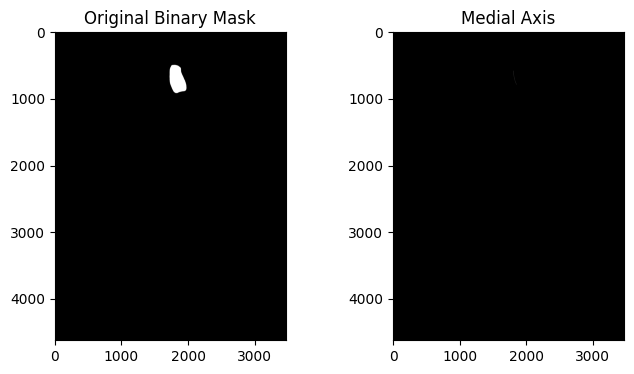

Length of medial axis: 209


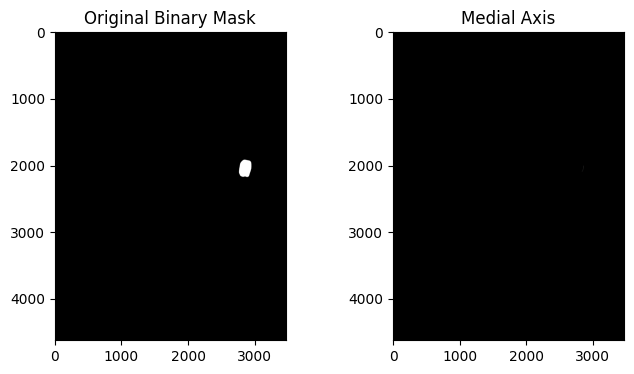

Length of medial axis: 93


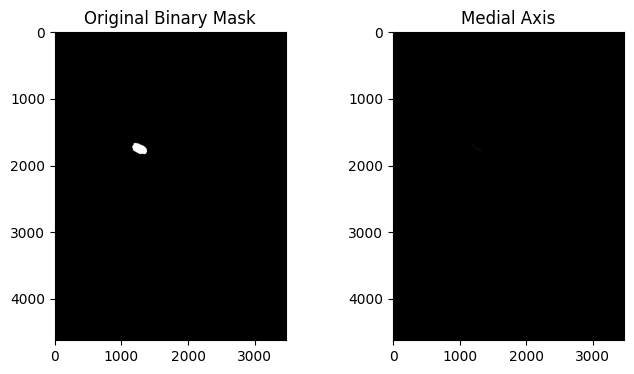

Length of medial axis: 176
Total length of all masks: 477


In [64]:
# pred_masks = outputs['instances'].get('pred_masks')

# # Assuming pred_masks_tensor is your binary tensor
# binary_masks = pred_masks.cpu().numpy()

# Convert to binary images (0 or 1)
binary_masks = pred_masks.astype(int)

# Combine all binary masks into a single binary image using logical OR
combined_mask = np.any(binary_masks, axis=0)

lengths = []

for mask in pred_masks:

    # Convert to binary images (0 or 1)
    # mask = mask.astype(int)
    # mask = mask != 0

    # Calculate the medial axis
    ax_medial = medial_axis(mask)

    # Visualize the original binary mask and its medial axis
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(mask, cmap='gray')
    axes[0].set_title('Original Binary Mask')
    axes[1].imshow(ax_medial, cmap='gray')
    axes[1].set_title('Medial Axis')

    plt.show()

    # Save length
    print("Length of medial axis:", np.count_nonzero(ax_medial))
    lengths.append(np.count_nonzero(ax_medial))

ax_medial = medial_axis(combined_mask)
print("Total length of all masks:", np.count_nonzero(ax_medial))

#### Old

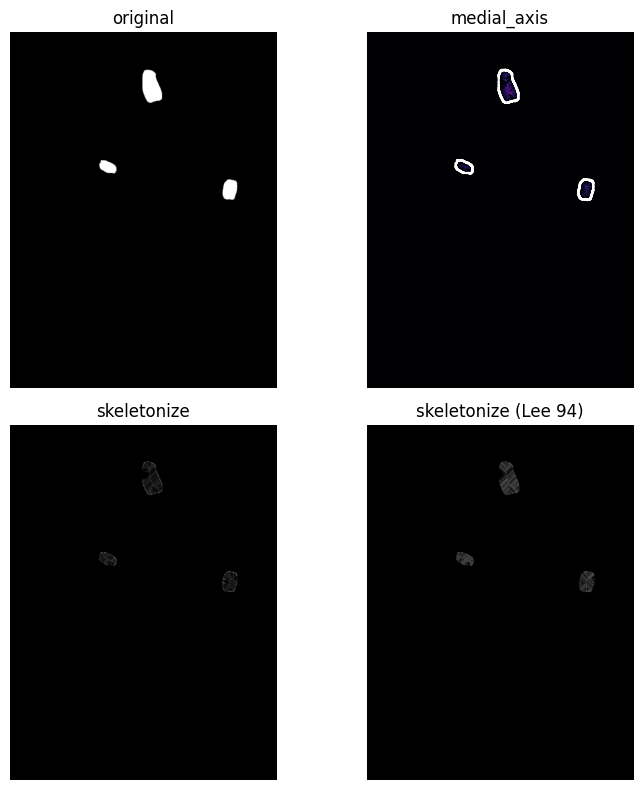

In [60]:
from skimage.filters import threshold_otsu
from skimage import io
from skimage.filters.rank import median
from skimage.morphology import disk,skeletonize,medial_axis,remove_small_objects
import matplotlib.pyplot as plt

# Read mask as image
imgIn = r"gdrive/My Drive/Master Geo Information Science/Internship/Data/Test/combined_mask.jpg"

blobs = cv2.imread(imgIn)
blobs = blobs[:, :, 0] != 0

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(blobs, return_distance=True)

# Compare with other skeletonization algorithms
skeleton = skeletonize(blobs)
skeleton_lee = skeletonize(blobs, method='lee')

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(blobs, cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(dist_on_skel, cmap='magma')
ax[1].contour(blobs, [0.5], colors='w')
ax[1].set_title('medial_axis')
ax[1].axis('off')

ax[2].imshow(skeleton, cmap=plt.cm.gray)
ax[2].set_title('skeletonize')
ax[2].axis('off')

ax[3].imshow(skeleton_lee, cmap=plt.cm.gray)
ax[3].set_title("skeletonize (Lee 94)")
ax[3].axis('off')

fig.tight_layout()
plt.show()

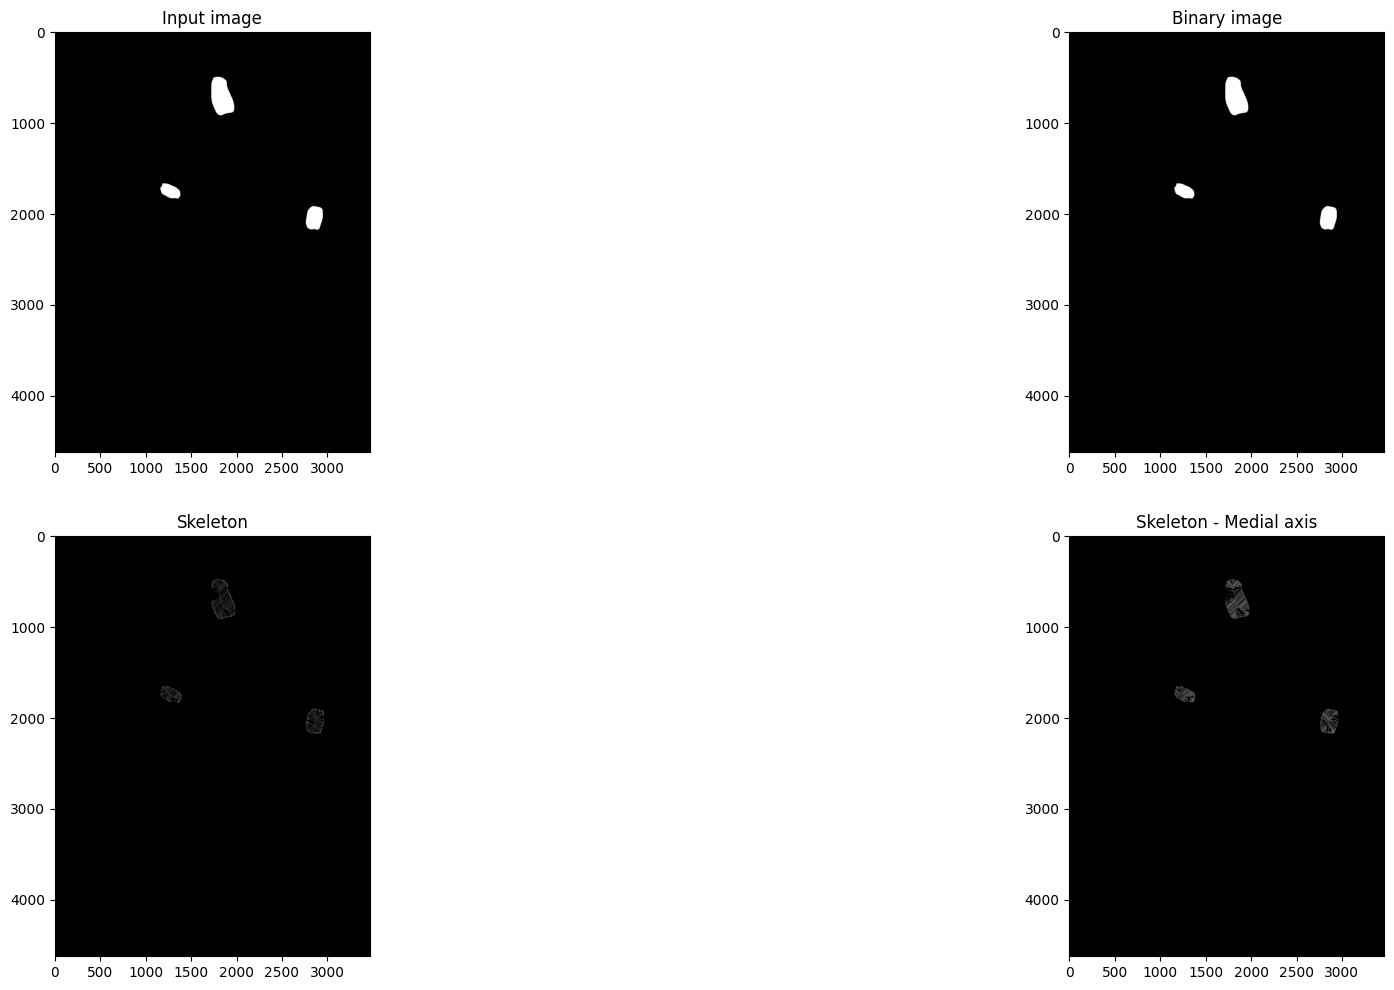

Length 1: 17856
Length 2: 31669


In [ ]:
from skimage.filters import threshold_otsu
from skimage import io
from skimage.filters.rank import median
from skimage.morphology import disk,skeletonize,medial_axis,remove_small_objects
import matplotlib.pyplot as plt

# Read mask as image
imgIn = r"gdrive/My Drive/Master Geo Information Science/Internship/Data/Test/combined_mask.jpg"

# If image is not binary
# input_image = io.imread(imgIn, as_gray=True, plugin=None)
# image = median(input_image, disk(15))
# thresh = threshold_otsu(image)
# image = image < thresh

image = cv2.imread(imgIn)
image = image[:, :, 0] # binary image with shape (M, N)
input_image = image

skel1=skeletonize(image)
skel2=medial_axis(image)
min_size=sum(sum(skel1))/2

# remove_small_objects(skel1,min_size=min_size,connectivity=5,in_place=True)
# remove_small_objects(skel2,min_size=min_size,connectivity=5,in_place=True)

fig2, ax = plt.subplots(2, 2, figsize=(24, 12))

ax[0,0].imshow(input_image,cmap=plt.cm.gray)
ax[0,0].set_title('Input image')
ax[0,0].axis('image')
ax[0,1].imshow(image, cmap=plt.cm.gray)
ax[0,1].set_title('Binary image')
ax[0,1].axis('image')
ax[1,0].imshow(skel1, cmap=plt.cm.gray)
ax[1,0].set_title('Skeleton')
ax[1,0].axis('image')
ax[1,1].imshow(skel2,cmap=plt.cm.gray)
ax[1,1].set_title('Skeleton - Medial axis')
ax[1,1].axis('image')

plt.show()

print ("Length 1: {0}".format(sum(sum(skel1))))
print ("Length 2: {0}".format(sum(sum(skel2))))